# Postprocessing with atooms 

In this notebook, we are going to show how to perform standard analysis of molecular dynamics trajectories using the **atooms** package and its **postprocessing** library. You can install both of them from pypi. 

We start with loading common libraries for plotting and path handling.

In [2]:
%matplotlib inline
import pylab as pl
import sys

We then import the **postprocessing** library and the trajectory class from **atooms**. In this particular case, we will read an XYZ file, so we load the **TrajectoryXYZ** class

In [3]:
import atooms.postprocessing as pp
from atooms.trajectory import TrajectoryXYZ 

We consider an example trajectory, located in the postprocessing package. We can grab it at this link https://gitlab.info-ufr.univ-montp2.fr/atooms/postprocessing/raw/master/data/kalj-small.xyz (we can download it from a terminal with wget). Let's store the path to this file in a variable for later convenience

In [4]:
path = "kalj-small.xyz"

## Handling a trajectory

A trajectory is an object with many properites. To load a trajectory, we create an instance of the class as follows

In [13]:
th = TrajectoryXYZ(path)

The trajectory is a list-like object, in the sense that it can be iterated up and sliced. Each frame of the trajectory contains a **System** object, which is a full configration of the system at a given instant of time during the simulation. Here we print the first, the 10th and the last frame

In [14]:
print th[0], th[10], th[-1]

<atooms.system.system.System object at 0x7f769d54be90> <atooms.system.system.System object at 0x7f769d54be10> <atooms.system.system.System object at 0x7f769d54bdd0>


 To know how many frames we have

In [15]:
print len(th)

101


To clarify: a slice is a list of frames, not a trajectory

In [8]:
th[10: 15]

Note: it is actually possible to define a slice of a trajectory *as a trajectory* by using the **Sliced** class decorator, see below.

If the trajectory contains metadata, these can be retrieved directly:

In [16]:
print "Timestep during the trajectory:", th.timestep
print "Steps corresponding to the 3rd frame:", th.steps[2]
print th._read_metadata(0)  # additional metadata

Timestep during the trajectory: 0.001
Steps corresponding to the 3rd frame: 2000
{'ndim': 3, 'npart': 150, 'cell': [5.0, 5.0, 5.0], 'step': 0, 'dt': 0.001, 'columns': ['name', 'pos']}


## Analysis of the trajectory

Now that we have constructed a trajectory object, we can proceed to the analysis. We are going to consider two main aspects of the analysis:
* structural correlations
* dynamical correlations

### Structural correlations : computing the *radial distribution function*

The radial distribution function *g(r)* describes how density varies as a function of the radial distance from a reference particle. In liquids, one normally averages over all particles, obtaining a descriptor of the probability to find a second particle a distance $r$ from a given particle, relative to that of the ideal gas.

For $N$ particles of the same type at density $\rho$ it is

$$g(r)=\frac{1}{N\rho}\left\langle\sum_i^{N}\sum_{i\neq j}\delta(r-|\mathbf{r}_i-\mathbf{r}_j|)\right\rangle$$.

Notice that the average number of particles with a distance $R$, i.e. the average **coordination** $n(R)$,  can be computed from the radial distribution function via integration in spherical coordinates (for 3D systems)

$$n(R)=4\pi \rho\int_0^R g(r)r^2 dr$$

In *postprocessing* the radial distribution function is a correlation object that acts on a trajectory. In order to compute it, we simpy construct the object, specifying some parameters, and then run the calculation with the **do()** method

In [17]:
gr = pp.RadialDistributionFunction(th, norigins=5, dr=0.04)
gr.do()

Once the calculation is performed, the radial distribution object gr contains (like all correlators in *postprocessing*) two arrays:
* the **grid** array contains the independent variable (or variables), binned according to our input parameters (in this case, the smallest space interval that we resolve, *dr*
* the **value** array contains the actual value of teh computation, in this case the values of the g(r)

We can directly plot the results with

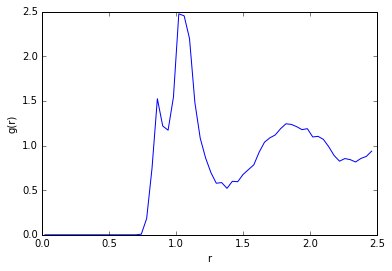

In [18]:
pl.plot(gr.grid, gr.value)
pl.xlabel("r"), pl.ylabel("g(r)");

As we can see, the function displays two narrow peaks around $r=1$ and a broader peak further away. The several peaks correspond to the fact that the trajectory actualy contains two types of particles, noted as "A" and "B". 

We can compute separate distribution functions for the A and B particles and also the cross distribution funtion for the probability to find a particle B at distance $r$ from particel $A$ using the **Partial** class in *postprocessing*:

In [20]:
gr = pp.Partial(pp.RadialDistributionFunction, species=['A', 'B'], trajectory=th, norigins=100)
gr.do() 

In this case, the result contains a dictionary *gr.partial*:

In [21]:
type(gr.partial)

dict

We can treat the result as any norrmal dictionary: 

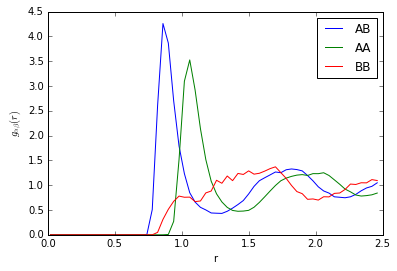

In [22]:
for key,g in gr.partial.items(): 
    pl.plot(g.grid, g.value, label=str("".join(key)))
pl.legend(); pl.xlabel("r"); pl.ylabel(r"$g_{\alpha\beta}(r)$");


Sometimes, it is useful to analyse only sections of a trajectory. To this purpose, one can **slice** the trajectory using *atooms* and analyse individual frames or subsets of frames. 

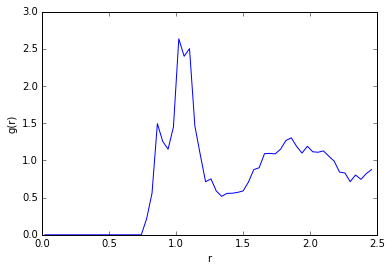

In [23]:
from atooms import trajectory

t =  trajectory.Sliced(th, slice(-1, len(th))) # analyse only the last frame
gr = pp.RadialDistributionFunction(t, dr=0.04)
gr.do()
pl.plot(gr.grid, gr.value)
pl.xlabel("r"); pl.ylabel("g(r)"); # notice that the g(r) is more noisy

### Dynamical Correlations: computing  the Mean Square Displacement

A very similar kind of anaysis can be performed on dynamical quantities, which quantify correlations in time.

The most elementary of such quantities is the mean squared displacement (MSD). This is defined as

$$ MSD(t)= \langle \mathbf{r}(t-t_0) - \mathbf{r}(t_0)\rangle$$

The average is normally perfomed over all the paricles $N$ and over multiple values for the *origin* of time $t_0$.

The analysis process is now familiar. First we cosntruct the msd object and then perform the calculation with **.do**.

In [24]:
msd = pp.MeanSquareDisplacement(th)
msd.do()

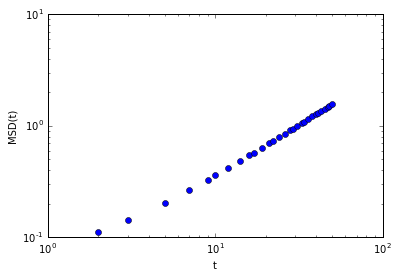

In [25]:
pl.loglog(msd.grid, msd.value, 'o')
pl.xlabel("t");  pl.ylabel("MSD(t)");

Again, we can compute partial mean square displacements using the **Partial** class

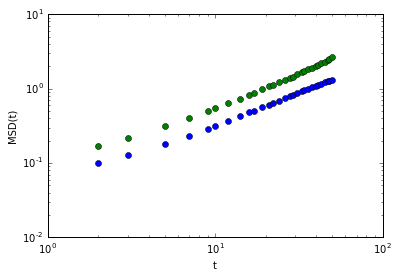

In [26]:
msds = pp.Partial(pp.MeanSquareDisplacement, species=['A','B'], trajectory=th, norigins=100)
msds.do()
pl.loglog(msds.partial['A'].grid, msds.partial['A'].value, 'o')
pl.loglog(msds.partial['B'].grid, msds.partial['B'].value, 'o')
pl.xlabel("t"); pl.ylabel("MSD(t)");

## Computing the Self Intermediate Scattering Function

We compute the intermediate scattering function (ISF) at specific wave-vectors using a logarithmic time grid.

In [29]:
isf = pp.Partial(pp.SelfIntermediateScattering, species=["A"], trajectory= th, kgrid=[2*pl.pi, 2.5*pl.pi], nk=1, tgrid=pl.logspace(0, 3, base=10))
isf.do()

To get some info on the parameters passed to compute the ISF, have a look at the help for the base class

In [35]:
help(pp.fourierspace.FourierSpaceCorrelation)

Help on class FourierSpaceCorrelation in module atooms.postprocessing.fourierspace:

class FourierSpaceCorrelation(atooms.postprocessing.correlation.Correlation)
 |  Base class for Fourier space correlation functions.
 |  
 |  The correlation function is computed for each of the scalar values
 |  k_i of the provided `kgrid`. If the latter is `None`, the grid is
 |  built using `ksamples` entries linearly spaced between `kmin` and
 |  `kmax`.
 |  
 |  For each sample k_i in `kgrid`, the correlation function is
 |  computed over at most `nk` wave-vectors (k_x, k_y, k_z) such that
 |  their norm (k_x^2+k_y^2+k_z^2)^{1/2} lies within `dk` of the
 |  prescribed value k_i.
 |  
 |  Method resolution order:
 |      FourierSpaceCorrelation
 |      atooms.postprocessing.correlation.Correlation
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, trajectory, grid, symbol, short_name, description, phasespace, nk=8, dk=0.1, kmin=-1, kmax=10, ksamples=20)
 |  
 |  repor

The ISF decays to zero at long times, as it should in an ergodic liquid.

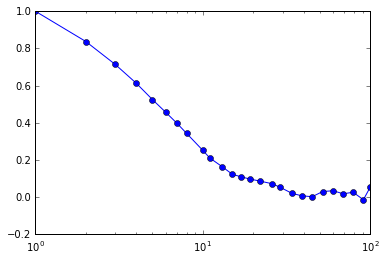

In [36]:
pl.semilogx(isf.partial['A'].grid[1], isf.partial['A'].value[0], '-o') 

We can extend the correlation class to compute additional correlation functions. The particle coordinates are loaded into the *\_pos* instance variable as a list of numpy arrays. Each numpy array is a (ndim, npart) representation of the full particles' coordinates in a given frame of the trajectory. This is a gist of a new correlation class.

In [47]:
from collections import defaultdict
import numpy

def some_function(x, pos):
    return 0.0

class NewCorrelation(pp.correlation.Correlation):
    def __init__(self, trajectory, grid):
        pp.correlation.Correlation.__init__(self, trajectory, grid, phasespace=["pos"])
   
    def _compute(self):
        print "Computing new correlation"
        raw = defaultdict(list)
        for i in range(len(self._pos)):
            for x in self.grid: 
                raw[x].append(some_function(x, self._pos[i]))        
        self.value = [numpy.mean(raw[x]) for x in raw]

In [48]:
nw = NewCorrelation(th, [0.0, 1.0])
nw.compute()

Computing new correlation


([0.0, 1.0], [0.0, 0.0])

*Author: Francesco Turci*